In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Get data

# Set to True to compare by sex and to False to compare by age
diff_by_sex = False

file_path = 'DATA.xlsx'

excel_data = pd.read_excel(file_path, usecols="A,D,E,U,X,AB,AC", nrows=78)
data = pd.DataFrame(excel_data)

if (diff_by_sex):
  data["brightness"] = np.nanmax(data[["bright 5", "bright 6"]], axis=1)
  data.drop(columns=["bright 5", "bright 6"])
  group1 = data[data["SEX"] == "F"]
  group2 = data[data["SEX"] == "M"]
else:
  group1 = data[data["AGE"] == 5].drop(columns=["bright 6"])
  group1.rename(columns={"bright 5": "brightness"}, inplace=True)
  group2 = data[data["AGE"] == 6].drop(columns=["bright 5"])
  group2.rename(columns={"bright 6": "brightness"}, inplace=True)

# print("group 1 data:\n", group1)
# print("group 2 data:\n", group2)

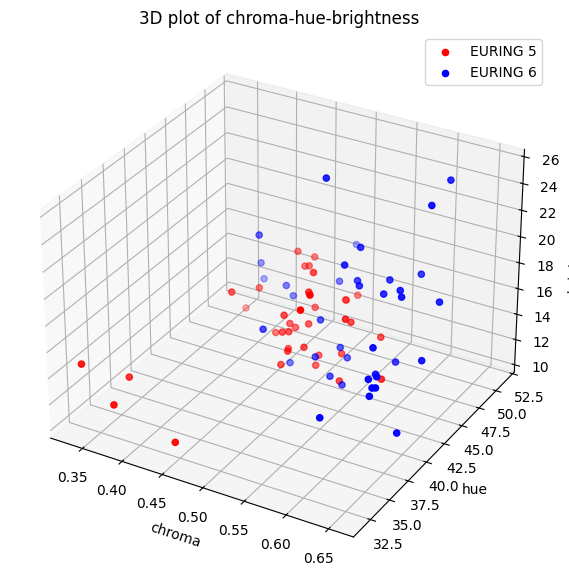

In [ ]:
## Scatter plot of chroma-hue-brightness in 3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

if (diff_by_sex):
  label1= "Female"
  label2 = "Male"
else:
  label1 = "EURING 5"
  label2 = "EURING 6"

# for i in range(len(group1)):
ax.scatter(xs=group1["chroma"], ys=group1["hue"], zs=group1["brightness"], c="r", label=label1)
ax.scatter(xs=group2["chroma"], ys=group2["hue"], zs=group2["brightness"], c="b", label=label2)
ax.legend()
ax.set_title("3D plot of chroma-hue-brightness")
ax.set_xlabel('chroma')
ax.set_ylabel('hue')
ax.set_zlabel('brightness')
plt.show()

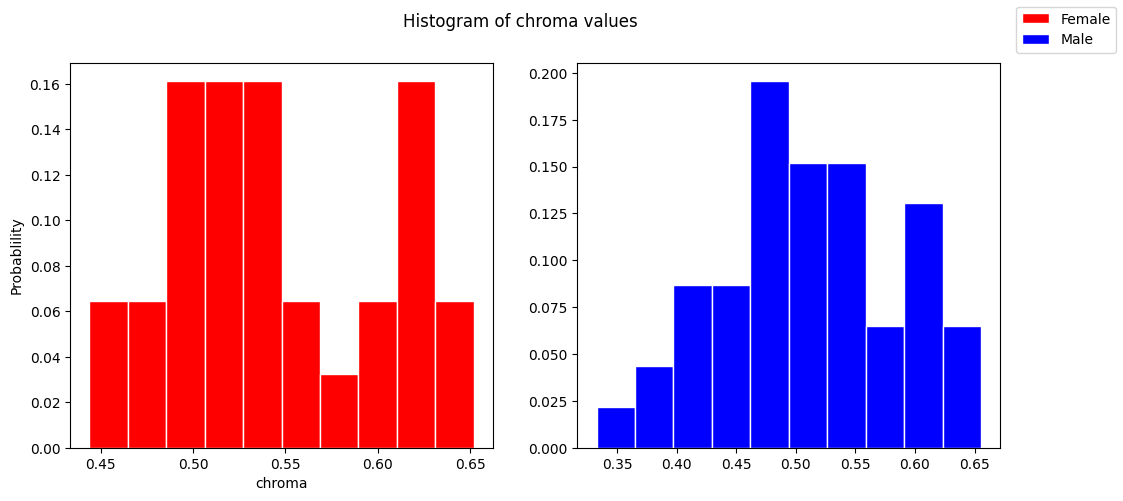

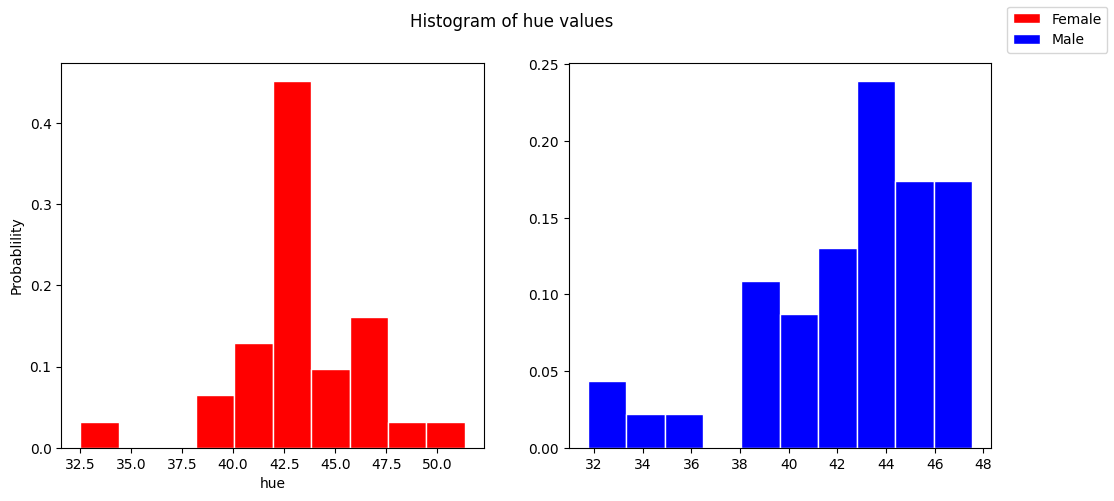

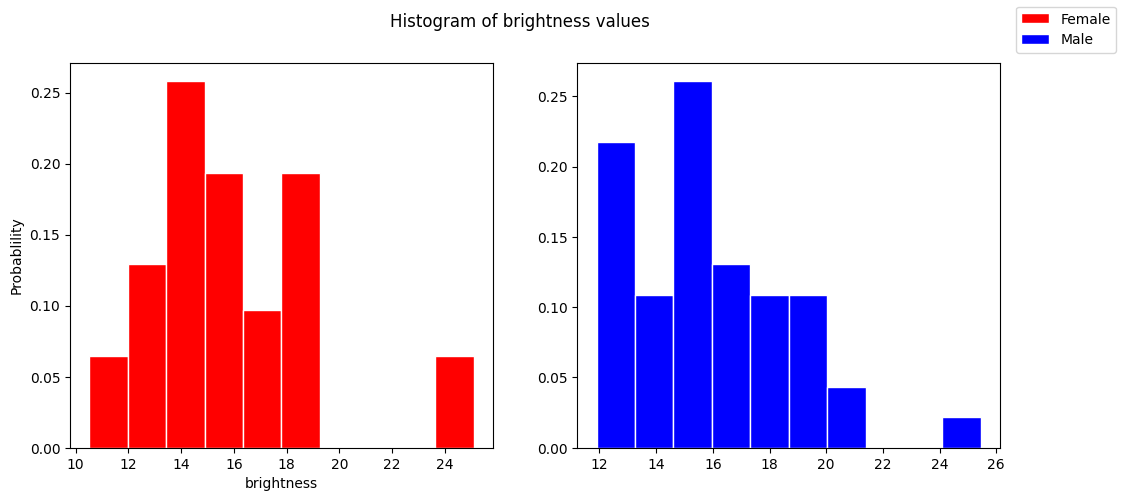

In [ ]:
# Calculate and plot histograms

parameters = ['chroma', 'hue', 'brightness']

for label in parameters:
  fig = plt.figure(figsize=(12,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)

  # Normalise the histogram values
  weights_group1 = np.ones_like(group1[label]) / len(group1[label])
  weights_group2 = np.ones_like(group2[label]) / len(group2[label])

  # Plot
  ax1.hist(group1[label], weights=weights_group1, edgecolor="w", color="r", label=label1)
  ax2.hist(group2[label], weights=weights_group2, edgecolor="w", color="b", label=label2)
  ax1.set_xlabel(label)
  ax1.set_ylabel("Probablility")
  fig.suptitle("Histogram of " + label + " values")
  fig.legend()

  plt.show()

In [ ]:
# Find and plot histogram and gaussian fit from data

from scipy.optimize import curve_fit

def gauss(X,C,X_mean,sigma):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

def histogram(x_data):
    hist, bin_edges = np.histogram(x_data)
    hist = hist/sum(hist)
    return hist, bin_edges

def fit_gauss(x_data):
    y_hist, bin_edges = histogram(x_data)
    x_hist = np.zeros((len(y_hist)),dtype=float)
    for i in range(len(x_hist)):
        x_hist[i]=(bin_edges[i+1]+bin_edges[i])/2
    mean = sum(x_hist*y_hist)/sum(y_hist)
    sigma = sum(y_hist*(x_hist-mean)**2)/sum(y_hist)
    param_optimised = curve_fit(gauss,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)[0]
    return param_optimised, x_hist

def plot_gauss_fit(ax, data, design, xlabel):
    xs, weights, x_hist, param = data
    label, color = design
    ax.hist(xs, weights=weights, edgecolor="w", color=color, label=label)
    ax.plot(x_hist, gauss(x_hist,*param), color="black", label='Gaussian fit')
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Probability")
    ax.legend()


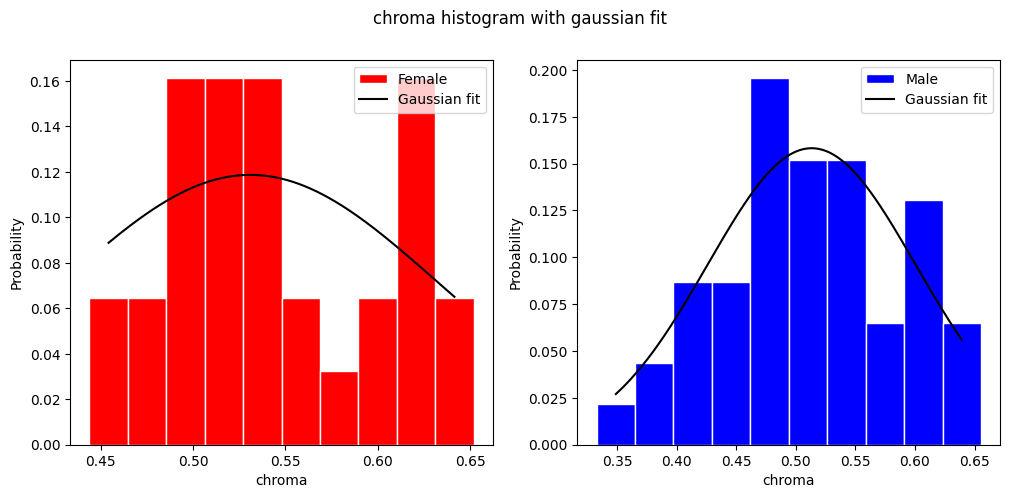

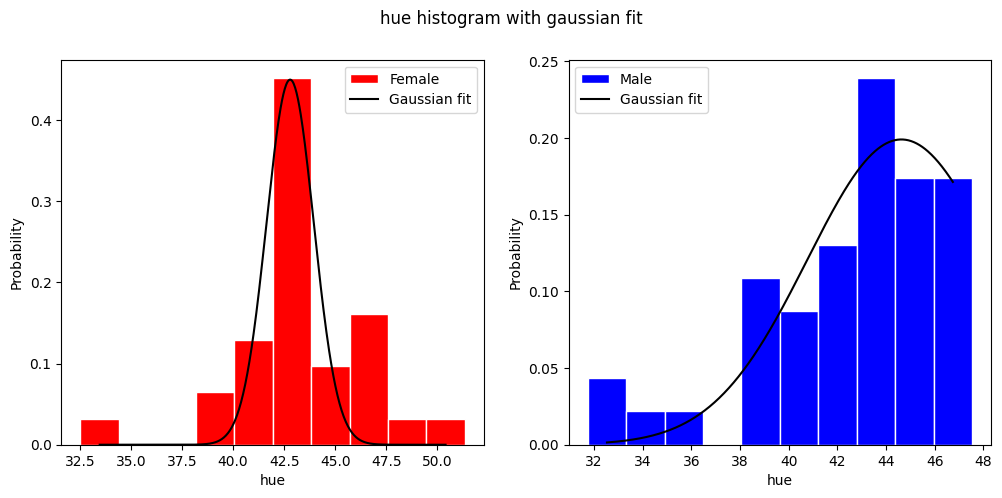

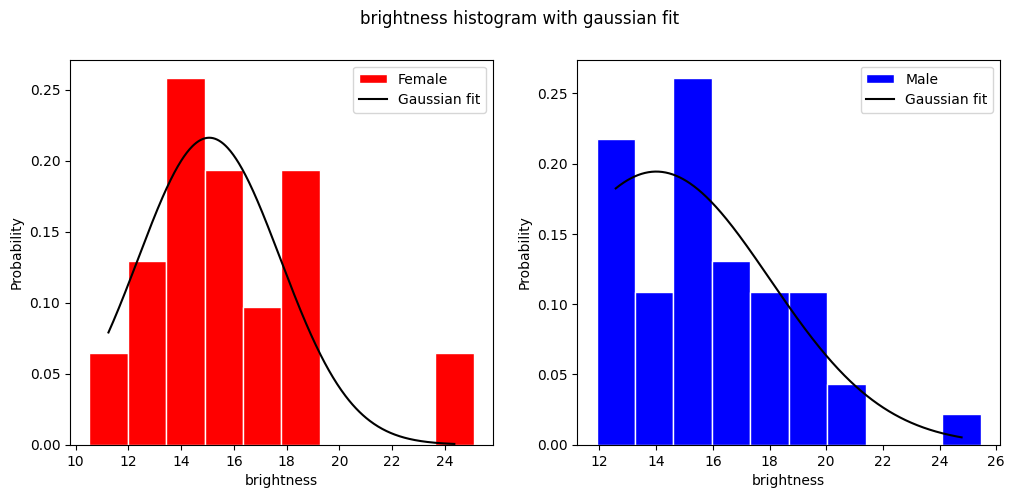

In [ ]:
# Fit gaussians to data

for label in parameters:
  fig = plt.figure(figsize=(12,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)

  # Group 1 fit
  param_group1, x_hist_group1 = fit_gauss(group1[label])
  x_hist_group1_2 = np.linspace(np.min(x_hist_group1),np.max(x_hist_group1),500)

  # Group 2 fit
  param_group2, x_hist_group2 = fit_gauss(group2[label])
  x_hist_group2_2 = np.linspace(np.min(x_hist_group2),np.max(x_hist_group2),500)

  # Plot
  data_group1 = group1[label], weights_group1, x_hist_group1_2, param_group1
  data_group2 = group2[label], weights_group2, x_hist_group2_2, param_group2
  design_group1 = label1, "r"
  design_group2 = label2, "b"
  plot_gauss_fit(ax1, data_group1, design_group1, label)
  plot_gauss_fit(ax2, data_group2, design_group2, label)
  plt.suptitle(label + " histogram with gaussian fit")

  plt.show()